https://youtu.be/KL4JwpuHdsU

**Segmenting whole slide images using a custom-trained Detectron2 model:**

<p>

We will be using a Mask R-CNN based trained model that we generated in our tutorial 336 (Github code starting with 336a).

<p>
This code walks you though the process of loading a WSI image (.svs format) and segmenting it by dividing the image into various patches. Then, putting the patches back into a large image (also handling the labels from the overlapped regions). Finally, saving the segmented large image. Here, we will also explore handling very large images that do not fit memory.

<p>

**Segmenting a whole slide image (WSI) - e.g., .svs image** <p>

Sample svs file: https://github.com/camicroscope/Distro/blob/master/images/sample.svs
<p>

A few large svs images can be downloaded from here: https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/ <p>


Please note that these are random files and have nothing to do with our training data. Therefore, not all nuclei will be segmented but we hope for some decent results. Ideally, you'd be segmenting images that are similar to our training data OR add more images to the training data to generalize the model.

**Install Detectron2**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15253, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 15253 (delta 143), reused 181 (delta 105), pack-reused 14979
Receiving objects: 100% (15253/15253), 6.28 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (11010/11010), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00

In [ ]:
# Let us make sure colab understands UTF-8.
# Without this Colab is giving an error when installing imagecodecs
# Obviously something that is relevant only for colab.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# To read Tiff files on Colab we need to install imagecodecs library
# This is a dependency of openslide library that we will be using to read .svs file
!pip install imagecodecs

# Install openslide
!pip install openslide-python

# Let us also install another dependency of openslide library
!sudo apt-get install libopenslide0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.3.0-cp310-cp310-linux_x86_64.whl size=33549 sha256=52185938bcf9461419d8a49b5f83103133d961f17a6fc87627196a1764060ca5
  Stored in directory: /root/.cache/pip/wheels/4d/a0/e6/e94ffceb76b28f1be2f59303ad58fdcf11822caa64960ed352
Successfully built openslide-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libopenslide0
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 89.8 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Fetched 89.8 kB in 0s (246 kB/s)
debcon

Verify the torch and detectron versions

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


Import the required libraries

In [ ]:
import openslide
from skimage.measure import label
import numpy as np
import cv2
print(openslide.__version__)

1.3.0


Load the .svs file

In [ ]:
# Read the svs image (or any other WSI format)
slide = openslide.OpenSlide("/content/drive/MyDrive/ColabNotebooks/data/svs_files/sample.svs") #sample.svs & my_slide.svs

In [ ]:
slide_dims = slide.dimensions
print(slide_dims)

(2220, 2967)


Define configuration and create a predictor object based on the config. This predictor will be used to predict on (segment) our image. The configuration includes the model structure (defined via a .yaml file) and populate the structure with appropriate weights (using .pth file). Do not forget to set an appropriate threshold. <p>

**Pro tip:** Extract a small region from the .svs file to run quick segmentation tests that help define an appropriate threshold.

In [ ]:
#from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_15k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

**Segmenting the large image by applying prediction tile by tile**

In the next step, let us break down the large image into smaller tiles, processes each tile to identify and label objects (Nuclei), and then stitch these processed tiles back together to create a full segmented mask of the original slide. <p>

We can svae the segmented mask as a 16-bit (or 32-bit) TIFF file for future use.

In [ ]:
import numpy as np
import tifffile  # to save our output as tiff
from skimage.measure import label  # for labeling the mask
from openslide import OpenSlide  # for reading slide images
import torch  # for using the predictor


# Parameters
tile_size = (512, 512)  # Size of the tile
overlap = 50  # Overlap between tiles

# Initialize an empty array to store the full mask
full_mask_shape = (slide.level_dimensions[-1][1], slide.level_dimensions[-1][0])
full_mask = np.zeros(full_mask_shape, dtype=np.uint16)

# Initialize a variable to keep track of the maximum label used so far
max_label = 0

# Loop through the slide and extract tiles
for x in range(0, slide.level_dimensions[0][0], tile_size[0] - overlap):
    print(f"Processing column starting at x = {x}")  # Start of Outer Loop
    for y in range(0, slide.level_dimensions[0][1], tile_size[1] - overlap):
        print(f"  Processing tile starting at (x, y) = ({x}, {y})")  # Start of Inner Loop
        # Calculate the size of the tile to read
        w, h = tile_size
        if x + w > slide.level_dimensions[0][0]:
            w = slide.level_dimensions[0][0] - x
        if y + h > slide.level_dimensions[0][1]:
            h = slide.level_dimensions[0][1] - y

        # Extract the tile from the slide
        tile = slide.read_region((x, y), 0, (w, h))
        tile_array = np.array(tile)[:, :, :3]  # Convert to NumPy array and keep only the RGB channels

        # Perform segmentation on the tile using our trained model
        outputs = predictor(tile_array)

        binary_mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(np.uint8)
        combined_mask = np.sum(binary_mask, axis=0)

        # Label the combined mask to give each object a unique integer value
        labeled_mask = label(combined_mask)

        # Update the labels to continue from where the last tile left off
        labeled_mask[labeled_mask > 0] += max_label

        # Update the maximum label used so far
        max_label = labeled_mask.max()

        print("    Segmentation complete.")  # After Segmentation

        # Update the full mask (handle overlaps using max pooling)
        #following code is ensuring that if there are overlapping regions between
        #labeled_mask and the full_mask, the full_mask will contain the maximum
        #values from both masks at those overlapping locations.
        # This is a common way to combine masks when handling segmentation tasks with overlaps.
        for i in range(h):
            for j in range(w):
                if y + i < full_mask_shape[0] and x + j < full_mask_shape[1]:  # Boundary check
                    full_mask[y + i, x + j] = max(full_mask[y + i, x + j], labeled_mask[i, j])
        print("    Full mask updated.")  # After Updating Full Mask

# Save the full mask as a 16-bit TIFF file
tifffile.imsave("/content/drive/MyDrive/ColabNotebooks/data/svs_files/detectron2_output_mask.tiff", full_mask.astype(np.uint16))


Processing column starting at x = 0
  Processing tile starting at (x, y) = (0, 0)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 462)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 924)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 1386)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 1848)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 2310)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (0, 2772)
    Segmentation complete.
    Full mask updated.
Processing column starting at x = 462
  Processing tile starting at (x, y) = (462, 0)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (462, 462)
    Segmentation complete.
    Full mask updated.
  Processing tile starting at (x, y) = (462, 924)
    Segmentation complete.
    Full mask updated.
  Processing tile star

<ipython-input-9-06b207ba1223>:64: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("/content/drive/MyDrive/ColabNotebooks/data/svs_files/detectron2_output_mask.tiff", full_mask.astype(np.uint16))


Plotting input image and the segmented image

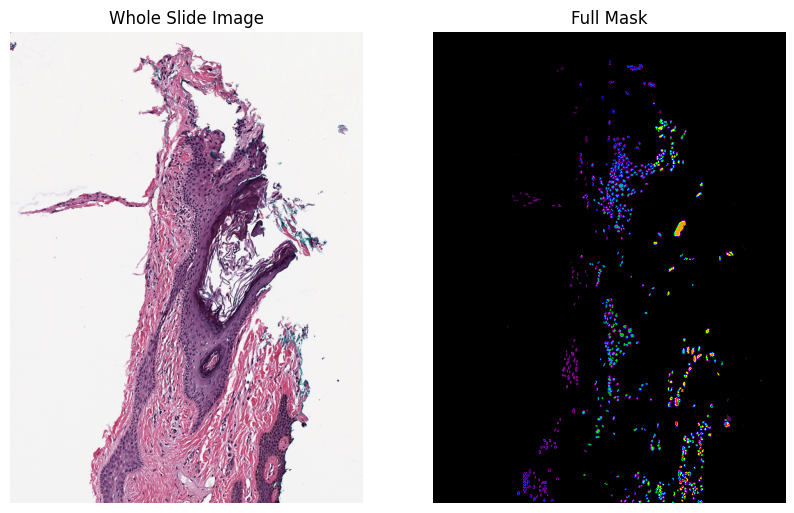

In [ ]:
import matplotlib.pyplot as plt

# Read the entire slide at the lowest resolution
lowest_level = len(slide.level_dimensions) - 1
whole_slide_image = slide.read_region((0, 0), lowest_level, slide.level_dimensions[lowest_level])
whole_slide_image = whole_slide_image.convert("RGB")  # Convert to RGB
whole_slide_image = np.array(whole_slide_image)  # Convert to NumPy array

# Plotting the whole slide image
plt.figure(figsize=(10, 120))

plt.subplot(1, 2, 1)
plt.imshow(whole_slide_image)
plt.title('Whole Slide Image')
plt.axis('off')

# Plotting the full mask
plt.subplot(1, 2, 2)
plt.imshow(full_mask, cmap='nipy_spectral')
plt.title('Full Mask')
plt.axis('off')

plt.show()


**How to work with images that do not fit in memory?** <p>
This is often the case with WSI slides but openslide is designed to handle it. In our code, 'slide' is an OpenSlide object that represents the whole slide image. OpenSlide is designed to read only the portions of the image that you request, so the entire image is not loaded into memory. <p>

But what about the full_mask that is the segmentation result from our slide? <br>
In our updated code below, 'full_mask' is a memory-mapped array, which is a disk-based storage that behaves like an in-memory array. This is created using np.memmap. When you write to full_mask, the data is written directly to disk, not stored in RAM. This allows you to work with very large arrays that don't fit into memory.

Let us download a large svs file. Here is a link I found from Google search.

In [ ]:
# !wget -O /content/drive/MyDrive/ColabNotebooks/data/svs_files/my_slide.svs https://www.dropbox.com/s/p9pjl3hgp8xvk0n/slide_x400.svs?dl=0

We will be working with our relatively small image for demonstration. Please go ahead and use the following code on a large image. Print statements are included to keep track of the progress.

In [ ]:
# Read the svs image (or any other WSI format)
#sample.svs or my_slide.svs
slide = openslide.OpenSlide("/content/drive/MyDrive/ColabNotebooks/data/svs_files/my_slide.svs")
slide_dims = slide.dimensions
print(slide_dims)

(120513, 88150)


In [ ]:
#Let's calculate roughly the amount of memory required by calculating the file size for our high resolution data.
file_size_bytes = slide_dims[0]*slide_dims[1]*24/8  #24 bit depth for RGB. 8 bits per byte.
file_size_GB =  file_size_bytes/(1024*1024*1024)
print("File size is: ", file_size_GB, " GB")

File size is:  29.68093645758927  GB


In [ ]:
#You don't have to work with the highest resolution, but as you go down in levels the resolution decreases.
#Your features of interest (nuclei) will not look the same as your training data.
dims = slide.level_dimensions
dims

((120513, 88150), (30128, 22037), (7532, 5509), (1883, 1377))

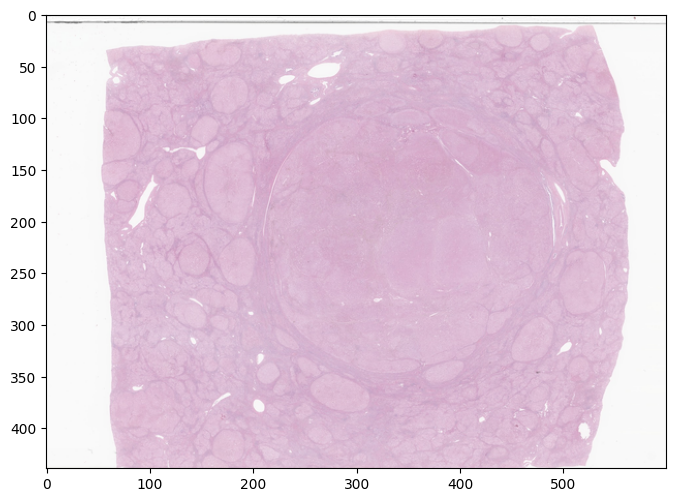

In [ ]:
#Get a thumbnail of the image and visualize
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
#Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np)

**Segmenting WSI tile by tile and holding results in a memory-mapped numpy array.**

In [ ]:
import numpy as np
from skimage.measure import label
import tifffile
import openslide
import time

# Parameters
tile_size = (512, 512)  # Size of the tile
overlap = 50  # Overlap between tiles
desired_level = 0  # User-defined level

# Initialize a memory-mapped array to store the full mask
full_mask_shape = (slide.level_dimensions[desired_level][1], slide.level_dimensions[desired_level][0])
full_mask = np.memmap("full_mask.dat", dtype=np.uint16, mode='w+', shape=full_mask_shape)

# Initialize a variable to keep track of the maximum label used so far
max_label = 0

# Calculate the total number of tiles
total_tiles = ((slide.level_dimensions[desired_level][0] - 1) // (tile_size[0] - overlap) + 1) * \
              ((slide.level_dimensions[desired_level][1] - 1) // (tile_size[1] - overlap) + 1)

# Initialize a variable to keep track of the processed tiles
processed_tiles = 0
# Initialize a variable to record the start time for each batch of 100 tiles
batch_start_time = None

#Batch size for printing
tracking_frequency = 10  #after every these many images, print

# Loop through the slide and extract tiles
for x in range(0, slide.level_dimensions[desired_level][0], tile_size[0] - overlap):
    for y in range(0, slide.level_dimensions[desired_level][1], tile_size[1] - overlap):

        # Record the start time for the first tile in each batch of 100
        if processed_tiles % tracking_frequency == 1:
            batch_start_time = time.time()

        # Calculate the size of the tile to read
        w, h = tile_size
        if x + w > slide.level_dimensions[desired_level][0]:
            w = slide.level_dimensions[desired_level][0] - x
        if y + h > slide.level_dimensions[desired_level][1]:
            h = slide.level_dimensions[desired_level][1] - y

        # Extract the tile from the slide
        tile = slide.read_region((x, y), desired_level, (w, h))
        tile_array = np.array(tile)[:, :, :3]  # Convert to NumPy array and keep only the RGB channels


        #print("Starting segmentation...")
        #start_time = time.time()
        # Perform segmentation on the tile using your trained model
        outputs = predictor(tile_array)
        #print(f"Segmentation complete. Time taken: {time.time() - start_time} seconds")

        binary_mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(np.uint8)
        combined_mask = np.sum(binary_mask, axis=0)

        # Label the combined mask to give each object a unique integer value
        labeled_mask = label(combined_mask)

        # Update the labels to continue from where the last tile left off
        labeled_mask[labeled_mask > 0] += max_label

        # Update the maximum label used so far
        max_label = labeled_mask.max()

        #print("Starting mask update...")
        #start_time = time.time()

        # Update the full mask (handle overlaps using max pooling)
        for i in range(h):
            for j in range(w):
                full_mask[y + i, x + j] = max(full_mask[y + i, x + j], labeled_mask[i, j])

        #print(f"Mask update complete. Time taken: {time.time() - start_time} seconds")

        # Update the number of processed tiles
        processed_tiles += 1
        #print("Moving on to tile number: ", processed_tiles)

        # Print progress every 100 tiles processed
        if processed_tiles % tracking_frequency == 0:
            #print(f"Processed {processed_tiles}/{total_tiles} tiles ({(processed_tiles / total_tiles) * 100:.2f}%)")
            batch_end_time = time.time()
            time_taken = batch_end_time - batch_start_time
            remaining_tiles = total_tiles - processed_tiles
            estimated_remaining_time_seconds = (remaining_tiles / tracking_frequency) * time_taken
            estimated_remaining_time_minutes = estimated_remaining_time_seconds / 60
            print(f"Processed {processed_tiles}/{total_tiles} tiles ({(processed_tiles / total_tiles) * 100:.2f}%) in {time_taken:.2f} seconds. Estimated remaining time: {estimated_remaining_time_minutes:.2f} minutes.")

# Save the full mask as a 16-bit or 32-bit TIFF file
tifffile.imsave(f"/content/drive/MyDrive/ColabNotebooks/data/svs_files/detectron2_output_mask_level_{desired_level}.tiff", full_mask)

# Export the entire raw image at the desired level
raw_image_pil = slide.read_region((0, 0), desired_level, slide.level_dimensions[desired_level])
raw_image = np.array(raw_image_pil)[:, :, :3]  # Convert to NumPy array and keep only the RGB channels
tifffile.imwrite(f"/content/drive/MyDrive/ColabNotebooks/data/svs_files/raw_image_level_{desired_level}.tiff", raw_image)


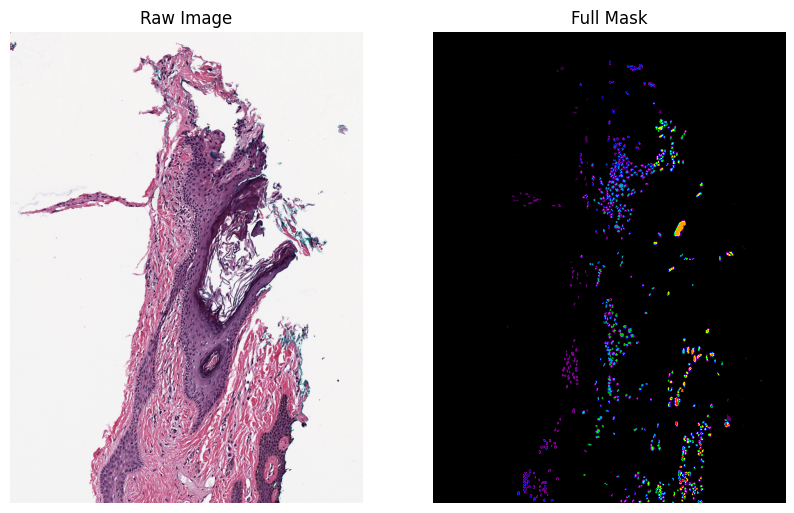

In [ ]:
import matplotlib.pyplot as plt

# Read the entire slide at the lowest resolution
lowest_level = len(slide.level_dimensions) - 1
whole_slide_image = slide.read_region((0, 0), lowest_level, slide.level_dimensions[lowest_level])
whole_slide_image = whole_slide_image.convert("RGB")  # Convert to RGB
whole_slide_image = np.array(whole_slide_image)  # Convert to NumPy array

# Plotting the whole slide image
plt.figure(figsize=(10, 120))

plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title('Raw Image')
plt.axis('off')

# Plotting the full mask
plt.subplot(1, 2, 2)
plt.imshow(full_mask, cmap='nipy_spectral')
plt.title('Full Mask')
plt.axis('off')

plt.show()